<a href="https://colab.research.google.com/github/sumanapalle065/LC25000-Hybrid-Architecture-using-DL/blob/main/LC25000_TriFusionNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TriFusionNet Hybrid Architecture for LC25000 Lung and Colon Histopathological Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
 !unzip "/content/drive/MyDrive/LC25000.zip"

Streaming output truncated to the last 5000 lines.
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc10.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc100.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1000.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1001.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1002.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1003.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1004.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1005.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1006.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1007.jpeg  
  inflating: lung_colon_image_set/lung_image_sets/lung_scc/lungscc1008.jpeg  
  inflating: lung_c

In [ ]:
# Import OpenCV library to perform computer vision tasks like image processing
import cv2

import numpy as np
import os
import glob
import matplotlib.pyplot as matplotlib
import random
import tqdm

from PIL import Image, ImageEnhance
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical # to transform a labels
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2, InceptionV3, EfficientNetB7
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Concatenate, Input, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model

from sklearn.metrics import precision_score, recall_score, f1_score#performance metrics to evaluate the model with precision, recall, F1 score

import seaborn as sns

from sklearn.metrics import precision_recall_curve, confusion_matrix, average_precision_score # to assess classification performance
from tensorflow.keras.callbacks import ModelCheckpoint #to save the best model in training based on specific conditions
from sklearn.model_selection import KFold # to train model on many splits of the data
from keras.models import load_model
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize #to convert labels into the binary format from which a multiclass classification could be made

In [ ]:
#load lung_colon_image_dataset
lung_colon_image_dataset=glob.glob("/content/lung_colon_image_set/*/*/*")

In [ ]:
lung_colon_image_dataset

['/content/lung_colon_image_set/colon_image_sets/colon_aca/colonca4811.jpeg',
 '/content/lung_colon_image_set/colon_image_sets/colon_aca/colonca1683.jpeg',
 '/content/lung_colon_image_set/colon_image_sets/colon_aca/colonca2352.jpeg',
 '/content/lung_colon_image_set/colon_image_sets/colon_aca/colonca4206.jpeg',
 '/content/lung_colon_image_set/colon_image_sets/colon_aca/colonca4349.jpeg',
 '/content/lung_colon_image_set/colon_image_sets/colon_aca/colonca2843.jpeg',
 '/content/lung_colon_image_set/colon_image_sets/colon_aca/colonca304.jpeg',
 '/content/lung_colon_image_set/colon_image_sets/colon_aca/colonca3998.jpeg',
 '/content/lung_colon_image_set/colon_image_sets/colon_aca/colonca4873.jpeg',
 '/content/lung_colon_image_set/colon_image_sets/colon_aca/colonca1788.jpeg',
 '/content/lung_colon_image_set/colon_image_sets/colon_aca/colonca1796.jpeg',
 '/content/lung_colon_image_set/colon_image_sets/colon_aca/colonca1618.jpeg',
 '/content/lung_colon_image_set/colon_image_sets/colon_aca/colonc

In [ ]:
len(lung_colon_image_dataset) # show len of lung_colon_image_dataset

25000

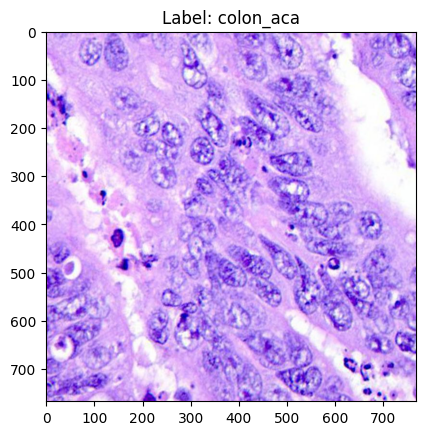

In [ ]:
# Select an image path at random from datset
random_image_path = random.choice(lung_colon_image_dataset)
# Read it in using OpenCV with the selected path
image = cv2.imread(random_image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
label = random_image_path.split('/')[-2]
matplotlib.imshow(image_rgb)
matplotlib.title(f"Label: {label}")
matplotlib.show()

#resize image

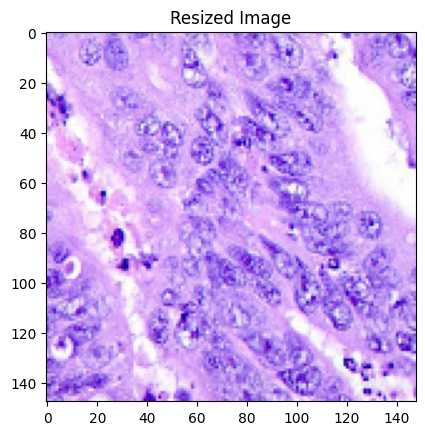

In [ ]:
# Resize the image to 148x148 with OpenCV's resize function for a fixed input size.
img = cv2.resize(image, (148, 148))
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
matplotlib.imshow(img_rgb)
matplotlib.title("Resized Image")
matplotlib.show()

#GaussianBlur

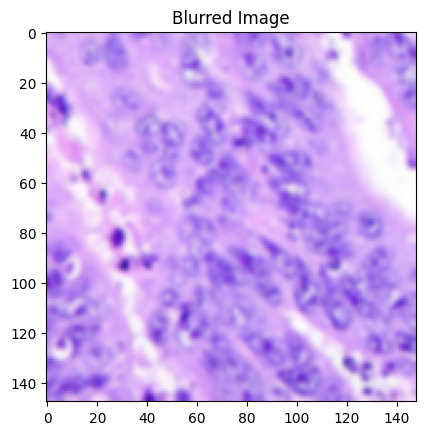

In [ ]:
#Apply Gaussian blur to the resized image with a 5x5 kernel, which will help in reducing noise and details.
blurred_img = cv2.GaussianBlur(img, (5, 5), 0)
blurred_img_rgb = cv2.cvtColor(blurred_img, cv2.COLOR_BGR2RGB)
matplotlib.imshow(blurred_img_rgb)
matplotlib.title("Blurred Image")
matplotlib.show()

#Denoised Image

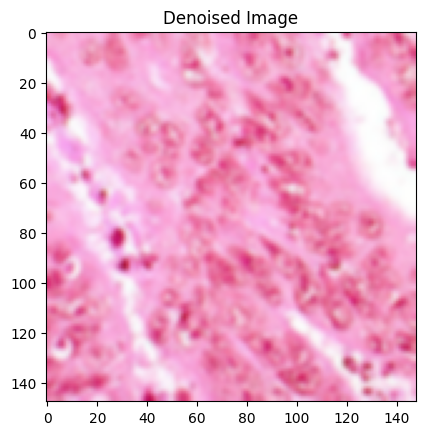

In [ ]:
# Converting the already blurred image (which was before in RGB format) to BGR color space again.
denoised_img_rgb = cv2.cvtColor(blurred_img_rgb, cv2.COLOR_BGR2RGB)
matplotlib.imshow(denoised_img_rgb)
matplotlib.title("Denoised Image")
matplotlib.show()

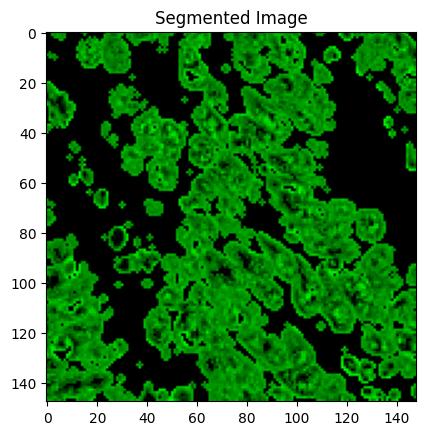

In [ ]:
# Convert RGB to grayscale while making use of the cvtColor function in OpenCV
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Apply Otsu's thresholding to the previous image. It creates the result in binary which is inverted.
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
# Capture the contours in the thresholded image with OpenCV's findContours function, to directly detect the boundaries of objects
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# Create empty mask of the same size to that of the initial image, and initialized to zero (black).
mask = np.zeros_like(img)
# Drawing the detected contours on the mask in green color with thickness 2 using OpenCV's drawContours function
cv2.drawContours(mask, contours, -1, (0, 255, 0), 2)
# bitwise AND operation to isolate the segmented region from the original image using the mask
segmented_image = cv2.bitwise_and(img, mask)
# Convert the segmented image from BGR color space to RGB so that colors are accurately displayed
matplotlib.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
matplotlib.title("Segmented Image")
matplotlib.show()


classifies medical images into five classes based on definition from label_map. Finds each picture path in dataset, resizes to 148x148 and then applies the following preprocessing steps: converts to grayscale; performs binary thresholding to distinguish regions of interest from the rest; enhances contrast by CLAHE; blur using Gaussian blur A mask is created to eliminate the segmented region if contours are present. The normalized and RGB formatted segmented region is applied before placing it in the processed_images list. The folder names of the picture path are taken to fetch labels as integers from the saved file label_map in the process of fetching labels. This gets the data ready to train a machine learning model.










In [ ]:
from tqdm import tqdm
# Initialize an empty list 'processed_images' to store the processed image data
processed_images = []
# Initialize an empty list 'labels' to hold the corresponding labels of the images
labels = []
# Define a class dictionary called 'label_map' that maps specific class names
label_map = {
    "lung_aca": 0,
    "colon_n": 1,
    "lung_n": 2,
    "lung_scc": 3,
    "colon_aca": 4,
}
# Iterate over the list of path to each image  with a progress bar
for img_path in tqdm(lung_colon_image_dataset):

    img = cv2.imread(img_path)
    # If the image has failed to load properly, skip the iteration and move to the next image
    if img is None:
      # Resize image to 148x148 pixels to standardize the size of input
        continue
    img = cv2.resize(img, (148, 148))
 # To blur the resized image by applying  kernel to remove noise in the image and blur.
    blurred_img = cv2.GaussianBlur(img, (5, 5), 0)

# Convert the blurry image to LAB color space-for better illumination handling
    lab = cv2.cvtColor(blurred_img, cv2.COLOR_BGR2LAB)
    # Split the LAB image into channels L, A and B
    l, a, b = cv2.split(lab)
    # Create a CLAHE object with some clip limit, tile grid size
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    # Applying CLAHE on the L channel (luminance) for contrast enhancement
    cl = clahe.apply(l)
    # Merging enhanced CLAHE L channel with original A and B channels
    lab_clahe = cv2.merge((cl, a, b))
    # Convert the LAB image back to BGR color space after CLAHE application
    img_clahe = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)
    # Convert CLAHE-enhanced image to grayscale for thresholding and contour detection
    gray = cv2.cvtColor(img_clahe, cv2.COLOR_BGR2GRAY)
    # Use OpenCV's Otsu's thresholding to the grayscale image to get a black and white image with inverted colors
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # Find contours of the object on the thresholded image using OpenCV's findContours function to detect boundaries and outlines
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # Create a mask of zeros filled with black for overlay onto the contours
    mask = np.zeros_like(img)
    # Detect contours in mask, draw them on it with green color, thickness of 2
    cv2.drawContours(mask, contours, -1, (0, 255, 0), 2)
    # Apply mask to the original image using bitwise AND to segment region of interest
    segmented_image = cv2.bitwise_and(img, mask)
    # Convert image from BGR to RGB for appropriate visualisation
    segmented_image_rgb = cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB)
 # Normalize the segmented image by converting its pixel values to float32 and scaling them to the range
    normalized_img = segmented_image_rgb.astype(np.float32) / 255.0
    # Append normalized image to 'processed_images
    processed_images.append(normalized_img)
    # Extract the class name from the parent directory of the image path that will be assumed as a label
    label = img_path.split(os.path.sep)[-2]
    # Check whether the extracted label is in 'label_map' dictionary or not
    if label in label_map:
      # If label is in 'label_map', append the numeric label corresponding to that one to the 'labels' list
        labels.append(label_map[label])

100%|██████████| 25000/25000 [02:10<00:00, 191.84it/s]


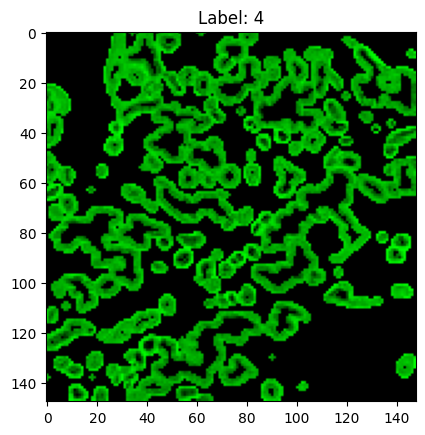

In [ ]:
# Choose an index to display the image and its label
index_to_display = 10  # Change this index to display a different image

# Display the image
matplotlib.imshow(processed_images[index_to_display])
matplotlib.title(f"Label: {labels[index_to_display]}")
matplotlib.show()

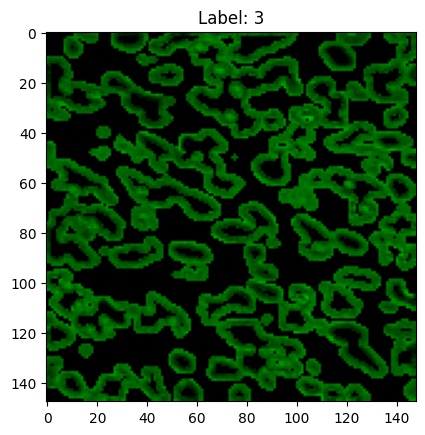

In [ ]:
# Choose an index to display the image and its label
index_to_display = 20000
# Display the image
matplotlib.imshow(processed_images[index_to_display])
matplotlib.title(f"Label: {labels[index_to_display]}")
matplotlib.show()

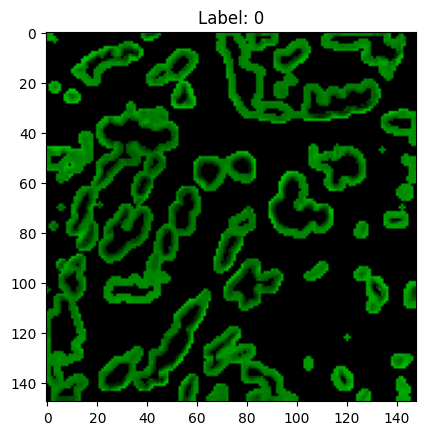

In [ ]:
# Choose an index to display the image and its label
index_to_display = 10000
# Display the image
matplotlib.imshow(processed_images[index_to_display])
matplotlib.title(f"Label: {labels[index_to_display]}")
matplotlib.show()

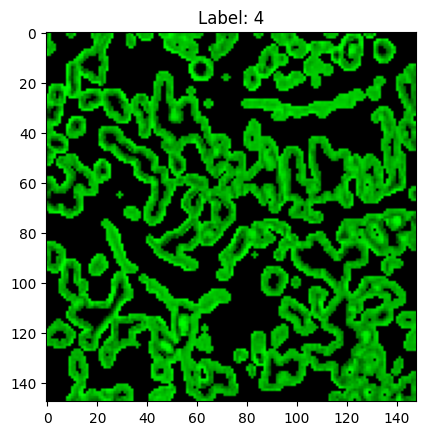

In [ ]:
# Choose an index to display the image and its label
index_to_display = 400
# Display the image
matplotlib.imshow(processed_images[index_to_display])
matplotlib.title(f"Label: {labels[index_to_display]}")
matplotlib.show()

In [ ]:
# The list of processed images should be converted into a form that is easily used and manipulated within deep learning models by using a NumPy array.
processed_images_array = np.array(processed_images)
# Convert the list of labels into a NumPy array to match the processed images for model training
labels_array = np.array(labels)
print("Shape of processed_images_array:", processed_images_array.shape)
print("Shape of labels_array:", labels_array.shape)


Shape of processed_images_array: (25000, 148, 148, 3)
Shape of labels_array: (25000,)


In [ ]:
# Splitting the dataset into training and testing sets using sklearn's train_test_split function
X_train, X_test, y_train, y_test = train_test_split(

    processed_images_array, labels_array, test_size=0.2, random_state=100
    # Setting random state for reproducibility so the split will always be the same
)

In [ ]:
#Print the shape of the training data & test data to confirm the dimensions
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (20000, 148, 148, 3)
X_test shape: (5000, 148, 148, 3)
y_train shape: (20000,)
y_test shape: (5000,)


In [ ]:
# Convert y_train, y_test to one-hot vector in Keras using to categorical
y_train = to_categorical(y_train, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)


In [ ]:
#Print the shape of one-hot encoded training & testing labels, to see how no.of samples and the dimensions of a one-hot encoded label
print("y_train_categorical shape:", y_train.shape)
print("y_test_categorical shape:", y_test.shape)

y_train_categorical shape: (20000, 5)
y_test_categorical shape: (5000, 5)


#TriFusionNet

By combining three pretrained networks—MobileNetV2, InceptionV3, and EfficientNetB7—as feature extractors and initializing their weights using the ImageNet dataset, a hybrid deep learning model is created. To extract more features, further convolutional and pooling layers are applied to the outputs of these frozen (non-trainable) models. To lessen overfitting, the collected features are then concatenated, globally pooled, and run through a number of fully connected layers that include dropout layers and batch normalization. Lastly, to predict five multi-label binary classes, a dense output layer with a sigmoid activation function is implemented. With a modest learning rate, categorical crossentropy as the loss function, and accuracy as the evaluation measure, the model is assembled using the Adam optimizer.

In [ ]:
# Input layer definition for the model, which takes images of size (148, 148, 3) in terms of height, width, and RGB channels.
input_layer = Input(shape=(148, 148, 3))
# Load the MobileNetV2 model with pre-trained weights from ImageNet but set include_top=False in order to use as a feature extractor
mobilenetv2_base = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_layer)
# Loading InceptionV3 model with weights pre-trained on ImageNet but removing the top layers by using include_top=False
inceptionv3_base = InceptionV3(weights='imagenet', include_top=False, input_tensor=input_layer)
# Load EfficientNetB7 pre-trained with ImageNet weights excluding top layers set to False for using as a feature extractor.
efficientnetb7_base = EfficientNetB7(weights='imagenet', include_top=False, input_tensor=input_layer)

# Set all of the models' pre-trained layers to frozen.
mobilenetv2_base.trainable = False
inceptionv3_base.trainable = False
efficientnetb7_base.trainable = False

# Get the outputs of all models
mobilenetv2_output = mobilenetv2_base.output
inceptionv3_output = inceptionv3_base.output
efficientnetb7_output = efficientnetb7_base.output

# Add CNN layers on top of MobileNetV2 output
mobilenetv2_output = Conv2D(256, (3, 3), activation='relu', padding='same')(mobilenetv2_output)
mobilenetv2_output = MaxPooling2D((2, 2))(mobilenetv2_output)

# Add CNN layers on top of InceptionV3 output
inceptionv3_output = Conv2D(256, (3, 3), activation='relu', padding='same')(inceptionv3_output)
inceptionv3_output = MaxPooling2D((2, 2))(inceptionv3_output)

# Add CNN layers on top of EfficientNetB7 output
efficientnetb7_output = Conv2D(256, (3, 3), activation='relu', padding='same')(efficientnetb7_output)
efficientnetb7_output = MaxPooling2D((2, 2))(efficientnetb7_output)

# Global Average Pooling for all models
mobilenetv2_output = GlobalAveragePooling2D()(mobilenetv2_output)
inceptionv3_output = GlobalAveragePooling2D()(inceptionv3_output)
efficientnetb7_output = GlobalAveragePooling2D()(efficientnetb7_output)

# Concatenate the outputs from all models
combined_output = Concatenate()([mobilenetv2_output, inceptionv3_output, efficientnetb7_output])
# Top the hybrid model with unique thick layers.
x = Dense(1024, activation='relu')(combined_output)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
# Adding the Dense layer with 1020 units and ReLU activation function
x = Dense(1020, activation='relu')(x)
# Applying BatchNormalization in order to normalize activations and improve convergence
x = BatchNormalization()(x)
# Dropout with 0.5 rate; this helps reduce overfitting where a half of the units are dropped at training time randomly
x = Dropout(0.5)(x)
# Another Dense layer of 1020 units with ReLU
x = Dense(1020, activation='relu')(x)
# BatchNormalization again for normalization of activations
x = BatchNormalization()(x)
# Dropout again with a dropout rate of 0.5 to discourage overfitting
x = Dropout(0.5)(x)
# Output layer of 5 units since we have 5 classes, and sigmoid activation for multiclass classification

output = Dense(5, activation='sigmoid')(x)
# Sigmoid activation outputs in [0, 1] so it's suitable for multiclass problems, and we assume independence between the class probabilities
hybrid_model = Model(inputs=input_layer, outputs=output)
# Hybrid Model: A model which has been defined as follows: Input layer Output layer
# loss function for the classification problem: since it is a multicategorical problem, use categorical crossentropy
hybrid_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                     # metric for which we will compute its accuracy while training
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# model summary to understand architecture and number of parameters
hybrid_model.summary()

<ipython-input-24-3c550fde9cf3>:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenetv2_base = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_layer)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 148, 148, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 148, 148, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 148, 148, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 148, 148, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 149, 149, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 74, 74, 64)     │          1,728 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 74, 74, 64)     │            256 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 74, 74, 64)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 74, 74, 64)     │            576 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 74, 74, 64)     │            256 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 74, 74, 64)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 64)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 64)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 16)       │          1,040 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 104,616,912 (399.08 MB)

 Trainable params: 16,452,329 (62.76 MB)

 Non-trainable params: 88,164,583 (336.32 MB)

In [ ]:
#Save the best model based on validation accuracy at training time with ModelCheckpoint
checkpoint = ModelCheckpoint(

    './BEST_Acc_save_MODEL.keras',
    monitor='val_accuracy',
    verbose=1, #message will be printed out when models are saved
    save_best_only=True, #best model for validation accuracy is saved.
    mode='max',
    save_freq='epoch'
)


In [ ]:
# Create a KFold cross-validation object with 5 splits. Data shuffeled before splitting.
kf = KFold(n_splits=5, shuffle=True, random_state=42)
# Initialize an empty list that will store the accuracy values for each fold
fold_accuracies = []
# Iterate through the KFold splits and create training and validation sets for each fold
for train_index, val_index in kf.split(X_train):

    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    # Using the indices to split X_train and y_train into training and validation subsets for the current fold
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    # Assigning the hybrid_model to a new variable 'model' for each fold (optional, but useful for avoiding state conflicts)
    model = hybrid_model
# Training the model on the current training fold and validating it on the corresponding validation fold
    history = model.fit(X_train_fold, y_train_fold,
                        # Fitting the model using the data for training
                        epochs=10,
                        validation_data=(X_val_fold, y_val_fold),
                        # And append checkpoint callback to save the best model according to val accuracy during training
                        batch_size=10,
                        callbacks=[checkpoint])

Epoch 1/10
1599/1600 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5778 - loss: 1.3496
Epoch 1: val_accuracy improved from -inf to 0.83275, saving model to ./BEST_Acc_save_MODEL.keras
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 190s 64ms/step - accuracy: 0.5779 - loss: 1.3493 - val_accuracy: 0.8328 - val_loss: 0.4528
Epoch 2/10
1599/1600 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7339 - loss: 0.8120
Epoch 2: val_accuracy did not improve from 0.83275
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 72s 45ms/step - accuracy: 0.7339 - loss: 0.8120 - val_accuracy: 0.8265 - val_loss: 0.4572
Epoch 3/10
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7705 - loss: 0.6469
Epoch 3: val_accuracy did not improve from 0.83275
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 72s 45ms/step - accuracy: 0.7705 - loss: 0.6469 - val_accuracy: 0.7707 - val_loss: 0.6262
Epoch 4/10
1599/1600 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7992 - loss: 0.5527
Epoch 4: val_accuracy improved from 0.83275 to 0.88700, saving model to ./BEST_Ac

In [ ]:
hybrid_model1 = load_model('/content/BEST_Acc_save_MODEL.keras')

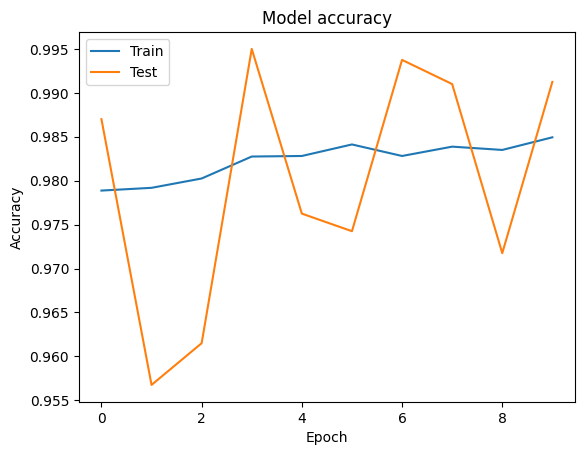

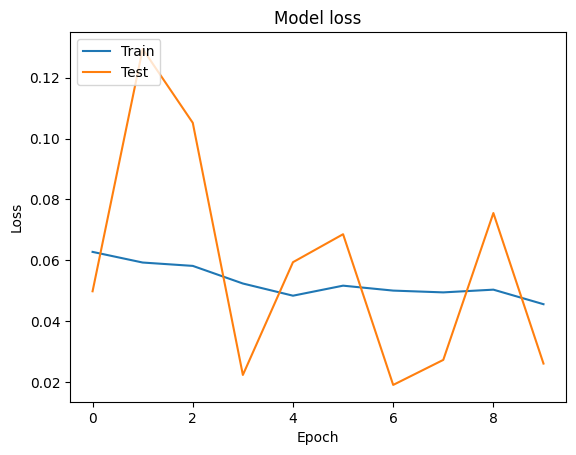

In [ ]:
#Plotting the training accuracy from the history object with matplotlib
matplotlib.plot(history.history['accuracy'])
matplotlib.plot(history.history['val_accuracy'])
matplotlib.title('Model accuracy')
matplotlib.ylabel('Accuracy')
matplotlib.xlabel('Epoch')
matplotlib.legend(['Train', 'Test'], loc='upper left')
matplotlib.show()

# Plot the training loss from the history object with matplotlib
matplotlib.plot(history.history['loss'])
matplotlib.plot(history.history['val_loss'])
matplotlib.title('Model loss')
matplotlib.ylabel('Loss')
matplotlib.xlabel('Epoch')
matplotlib.legend(['Train', 'Test'], loc='upper left')
matplotlib.show()



In [ ]:
#Evaluate the model on the current training fold to yield loss and accuracy
train_loss, train_acc = hybrid_model1.evaluate(X_train_fold, y_train_fold)
print('\nTrain accuracy:', train_acc)

500/500 ━━━━━━━━━━━━━━━━━━━━ 59s 47ms/step - accuracy: 0.9969 - loss: 0.0162

Train accuracy: 0.9965624809265137


In [ ]:
#Evaluate the model on the current validation fold to calculate loss and accuracy.
test_loss, test_acc = hybrid_model1.evaluate(X_val_fold, y_val_fold)
# Prints the accuracy of the validation after calling the function, which evaluates the model on the validation fold
print('\nTest accuracy:', test_acc)

125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.9948 - loss: 0.0184

Test accuracy: 0.9944999814033508


#Training results

In [ ]:

# Use the hybrid_model1 to provide predictions for the training fold.
y_pred = hybrid_model1.predict(X_train_fold)

# Create class labels based on the anticipated probability.
y_pred_classes = np.argmax(y_pred, axis=1)

500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step


In [ ]:
y_train_fold = np.argmax(y_train_fold, axis=1)

In [ ]:
# Calculate average precision score over predicted classes all classes weighted by their frequency
precision = precision_score(y_train_fold, y_pred_classes, average='weighted')
f1 = f1_score(y_train_fold, y_pred_classes, average='weighted')
print("Precision:", precision)
print("F1-score:", f1)

Precision: 0.9965855991034269
F1-score: 0.9965579114238594




#Plotting a confusion matrix

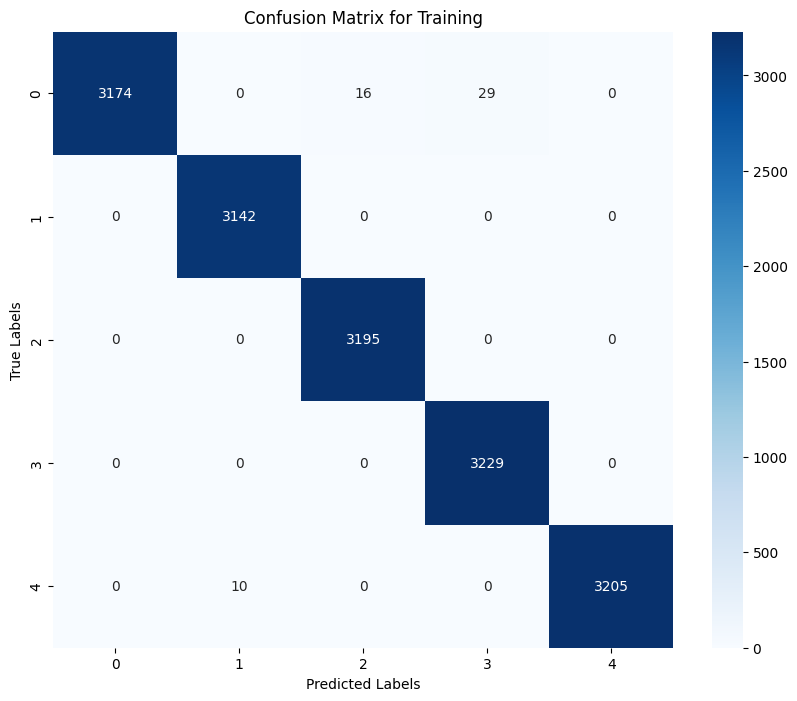

In [ ]:
# True-label-based confusion matrix and class-label-based predictions
cm = confusion_matrix(y_train_fold, y_pred_classes)
matplotlib.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(5), yticklabels=range(5))
matplotlib.xlabel('Predicted Labels')
matplotlib.ylabel('True Labels')
matplotlib.title('Confusion Matrix for Training')
matplotlib.show()

In [ ]:
# Computing the sensitivity (also called recall or true positive rate)
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
print('Sensitivity : ', sensitivity)
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
print('Specificity : ', specificity)

Sensitivity :  1.0
Specificity :  1.0


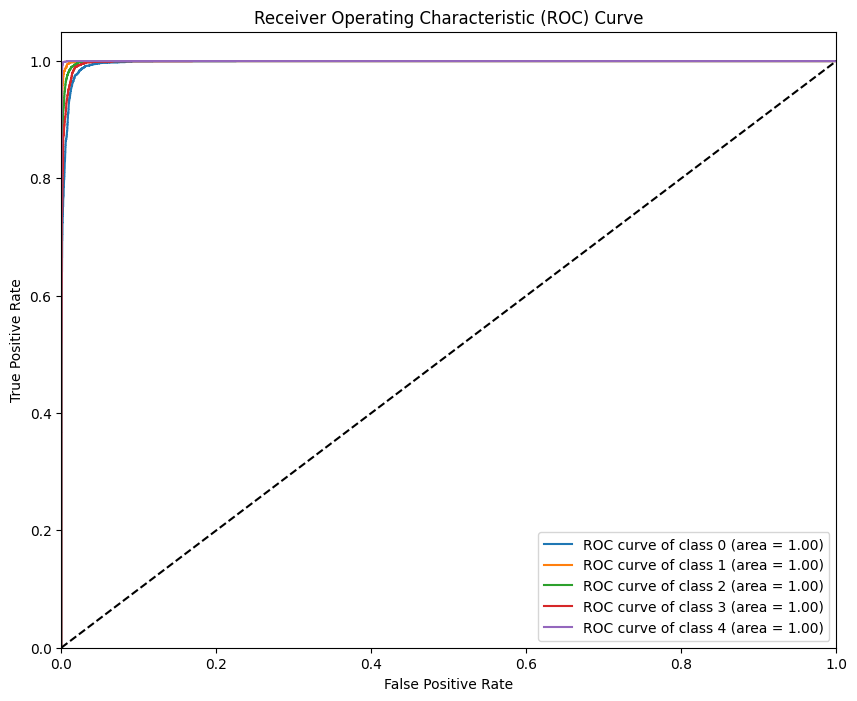

In [ ]:
#calculate roc auc curve plot graph
# To calculate the ROC AUC, binarize the labels.
y_train_bin = label_binarize(y_train_fold, classes=range(5))
y_pred_bin = y_pred

# Initializes dictionaries to store false positive rate (fpr), true positive rate (tpr) and ROC AUC values for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
# Loops the value 0 through 4
for i in range(5):

    fpr[i], tpr[i], _ = roc_curve(y_train_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Drawing ROC Curve for each of the 5 classes
matplotlib.figure(figsize=(10, 8))

for i in range(5):

    matplotlib.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

# Plotting a diagonal line that reflects the performance of a random classifier with no discrimination
matplotlib.plot([0, 1], [0, 1], 'k--')
matplotlib.xlim([0.0, 1.0])
matplotlib.ylim([0.0, 1.05])
matplotlib.xlabel('False Positive Rate')
matplotlib.ylabel('True Positive Rate')
matplotlib.title('Receiver Operating Characteristic (ROC) Curve')
matplotlib.legend(loc="lower right")
matplotlib.show()# Show the plot

Computes and plots the PR curves of a multi-class classification problem. It computes precision, recall, and average precision for each class with the precision_recall_curve and average_precision_score functions, storing their results in lexicons. All classes' PR curves in one plot, with each class's legend containing the AP score. The plot is titled "Precision-Recall Curve" with labeled axes ("Recall" and "Precision"). Legend in lower-left corner separates classes' PR curves and is used to evaluate model's performance at different thresholds.











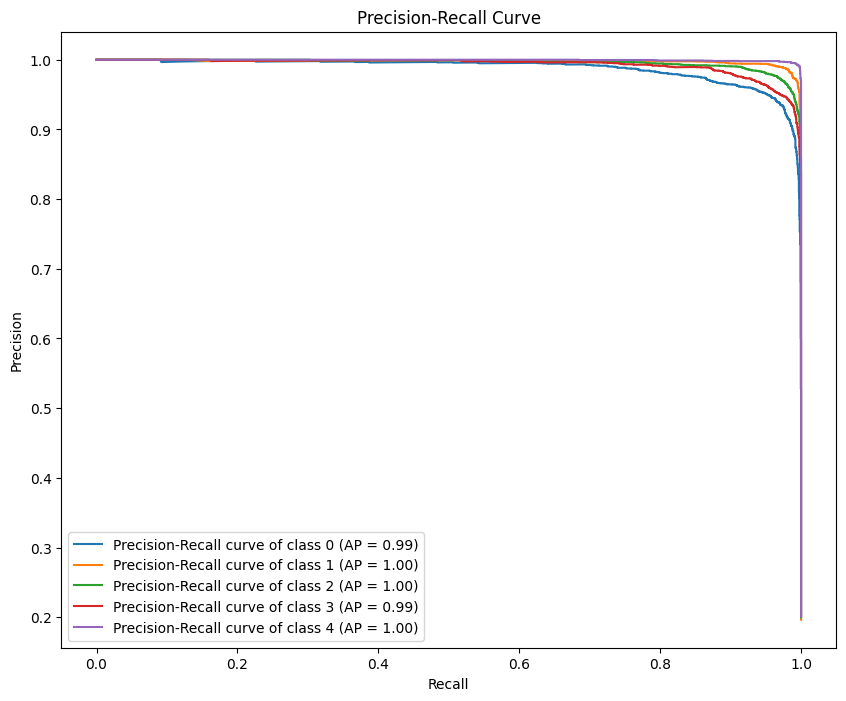

In [ ]:
# Initialize dictionaries to store the precision, recall, and average precision for each class
precision = dict()
recall = dict()
average_precision = dict()

# Obain the average precision (AP) of each class using the function average_precision_score that summarizes the precision-recall curve into a single number
# Iterate over the 5 classes (0 to 4)
for i in range(5):

    precision[i], recall[i], _ = precision_recall_curve(y_train_bin[:, i], y_pred_bin[:, i])
    average_precision[i] = average_precision_score(y_train_bin[:, i], y_pred_bin[:, i])

matplotlib.figure(figsize=(10, 8))

for i in range(5):

    matplotlib.plot(recall[i], precision[i], label='Precision-Recall curve of class {0} (AP = {1:0.2f})'.format(i, average_precision[i]))

matplotlib.xlabel('Recall')
matplotlib.ylabel('Precision')
matplotlib.title('Precision-Recall Curve')
# Each curve is labeled with the class number and the corresponding AP value, rounded to two decimal
matplotlib.legend(loc="lower left")
matplotlib.show()


#Testing Results

In [ ]:
## Predict the output of the validation set (X_val_fold) according to the trained model: hybrid_model1
# Convert predicted probabilities to class labels by selecting index of max probability for each sample
y_pred = hybrid_model1.predict(X_val_fold)
y_pred_classes = np.argmax(y_pred, axis=1)

125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step


In [ ]:
#Convert the one-hot encoded ground truth labels in 'y_val_fold' to class labels
y_val_fold = np.argmax(y_val_fold, axis=1)

In [ ]:
# Calculate the precision and F1-score of the validation set y_val_fold and y_pred_classes by averaging the weights.
# Precision measures the fraction of true positive predictions over all positive predictions, that is to say, how many of the predicted positive labels are correct
precision = precision_score(y_val_fold, y_pred_classes, average='weighted')
f1 = f1_score(y_val_fold, y_pred_classes, average='weighted')
print("Precision:", precision)
print("F1-score:", f1)

Precision: 0.9945509931503523
F1-score: 0.9944898167570384


This code computes and plots the Receiver Operating Characteristic (ROC) curves for a multi-class classification problem. As the task is multi-class, it first binarizes the predictions, y_pred_bin, and true labels, y_test_bin, in order to be able to compute AUC, TPR, and FPR for every class where it applies the roc_curve and auc functions in that module. For every class, it outputs ROC curves along with the values of AUC on the legend. The graph is adequately labeled and titled, with a diagonal reference line that highlights random performance. It depicts how well the classifier would distinguish between classes in the final plot.











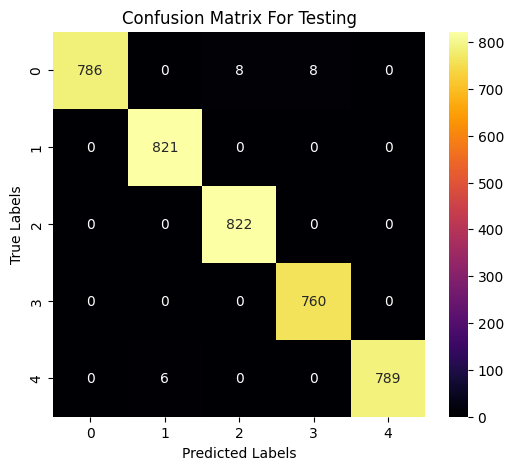

In [ ]:
#confusion matrix
# To compute the confusion matrix, (`y_val_fold`) and predicted labels (`y_pred_classes`).
cm = confusion_matrix(y_val_fold, y_pred_classes)
# Create a new figure for the plot with dimensions 6x5 inches
matplotlib.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='inferno', xticklabels=range(5), yticklabels=range(5))
matplotlib.xlabel('Predicted Labels')
matplotlib.ylabel('True Labels')
matplotlib.title('Confusion Matrix For Testing')
matplotlib.show()


This code computes and plots the Receiver Operating Characteristic (ROC) curves for a multi-class classification problem. As the task is multi-class, it first binarizes the predictions, y_pred_bin, and true labels, y_test_bin, in order to be able to compute AUC, TPR, and FPR for every class where it applies the roc_curve and auc functions in that module. For every class, it outputs ROC curves along with the values of AUC on the legend. The graph is adequately labeled and titled, with a diagonal reference line that highlights random performance. It depicts how well the classifier would distinguish between classes in the final plot.











In [ ]:
# Calculation for Sensitivity (True Positive Rate) for class 0
sensitivity1 = cm[0,0]/(cm[0,0]+cm[0,1])
#The number of actual positives correctly identified
print('Sensitivity : ', sensitivity1 )
# Specificity or True Negative Rate for class 1
specificity1 = cm[1,1]/(cm[1,0]+cm[1,1])
# Specificity is the number of actual negatives correctly classifier
print('Specificity : ', specificity1)

Sensitivity :  1.0
Specificity :  1.0


The code will calculate and plot the Precision-Recall (PR) curve for a five-class multi-class classification. Precision, recall, and the Average Precision (AP) score for every class are computed using Precision_recall_curve and average_precision_score. Dictionaries include all those measures. Each class has the corresponding PR curve with AP included in the legend. In order to differentiate the curves for each of the classes, a legend has been added to the bottom left hand side of the plot along with proper titles and axis names. The plot is finally plotted.











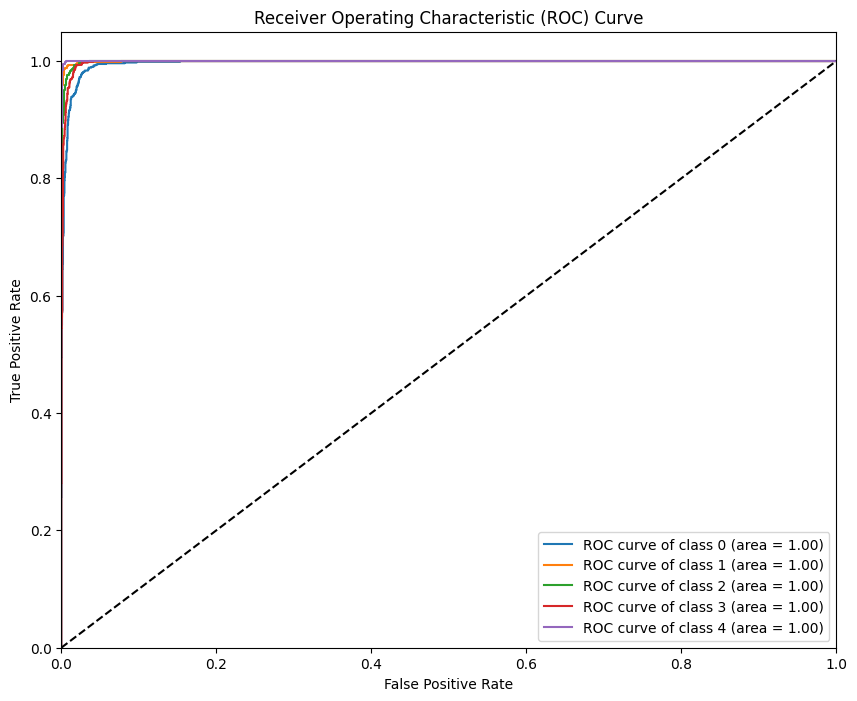

In [ ]:
# Binarizing the true labels 'y_val_fold' for multi-class classification with 12 classes (classes are labeled from 0 to 11)
y_test_bin = label_binarize(y_val_fold, classes=range(12))
#line 'label_binarize' translates labels into one-hot encoded format where each class label is represented by a binary vector
y_pred_bin = y_pred
# y_pred is already in the same format - this keeps it that way
fpr = dict()
# Initializing dictionaries to store the false positive rate
tpr = dict()
# true positive rate (tpr), and area under the curve
roc_auc = dict()

for i in range(5):
  # Plot the ROC curve (fpr, tpr) for each class by using the true labels (y_test_bin) and predicted probabilities (y_pred_bin).
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    # Calculate the Area Under the Curve (AUC) for each class
    roc_auc[i] = auc(fpr[i], tpr[i])

# Generating a figure for plotting ROC curves for each class
matplotlib.figure(figsize=(10, 8))

for i in range(5):
    # Plot the ROC curve for class `i`, including the AUC (area under the curve) score in the legend
    matplotlib.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

# Draw a diagonal line that shows the performance of a random classifier (no discrimination ability).

matplotlib.plot([0, 1], [0, 1], 'k--')

# Plotting the ROC curves of all classes in multiclass classification
matplotlib.xlim([0.0, 1.0])
#These limits ensure that the ROC curve fits in the usual range [0, 1] for both axes
matplotlib.ylim([0.0, 1.05])
matplotlib.xlabel('False Positive Rate')
matplotlib.ylabel('True Positive Rate')
matplotlib.title('Receiver Operating Characteristic (ROC) Curve')
matplotlib.legend(loc="lower right")
matplotlib.show()


The code calculates and plots the Precision-Recall (PR) curve for a five-class multi-class classification problem. For each class, precision, recall, and the Average Precision (AP) score are calculated via precision_recall_curve and average_precision_score. These measurements are kept in dictionaries. Then, for every class, the PR curve matching that is plotted with AP represented in the legend. To make each curve distinguishable, a proper title and the names for the axes are included at the bottom left corner of the graph, and there is an explanation in the form of a legend. The plot is finally presented.











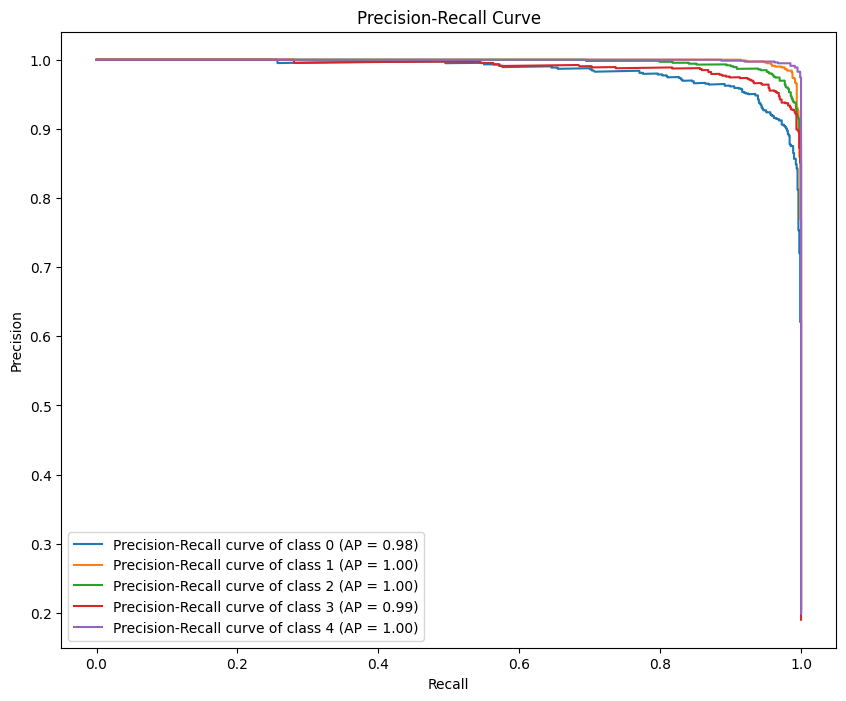

In [ ]:
#Initialize dictionaries: Initialize empty dictionaries to store precision, recall, and average precision for the 5 classes.
precision = dict()
recall = dict()
average_precision = dict()

for i in range(5):

    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_pred_bin[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_pred_bin[:, i])

matplotlib.figure(figsize=(10, 8))
for i in range(5):

    matplotlib.plot(recall[i], precision[i], label='Precision-Recall curve of class {0} (AP = {1:0.2f})'.format(i, average_precision[i]))

matplotlib.xlabel('Recall')
matplotlib.ylabel('Precision')
matplotlib.title('Precision-Recall Curve')
matplotlib.legend(loc="lower left")
matplotlib.show()



# Prediction

uses a trained model (hybrid_model1) to predict classes for the first ten photos of the test set; it uses np.argmax to turn the probabilistic outputs of the model into class labels. Each relevant image is shown with the title of its anticipated class, and the expected class labels are shown. Iterating through the first ten test photos, matplotlib.imshow() is used to visualize each one, and the title is changed to reflect the projected class.










1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step
Predicted classes for the first 10 images: [3 2 4 3 2 2 2 3 0 3]


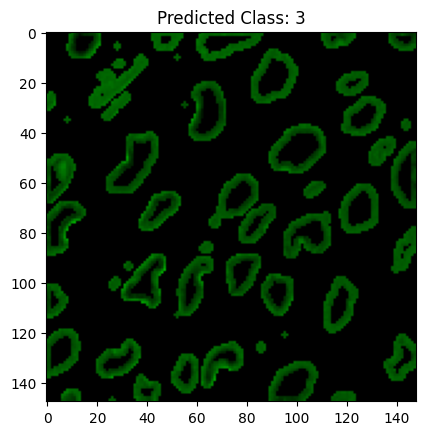

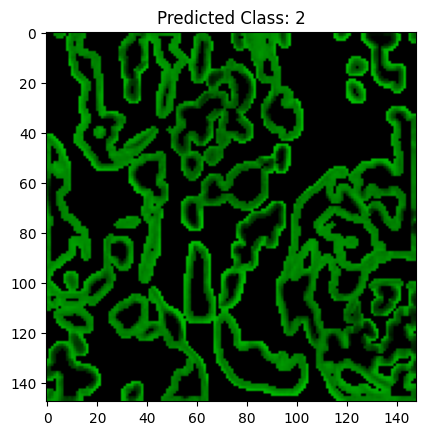

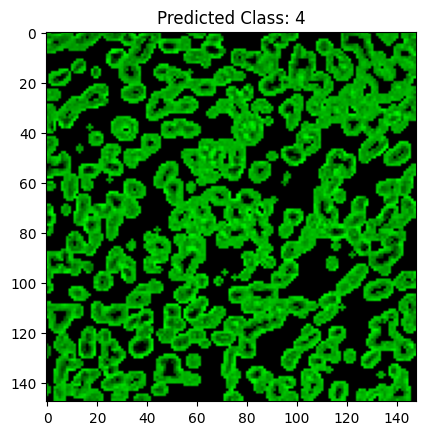

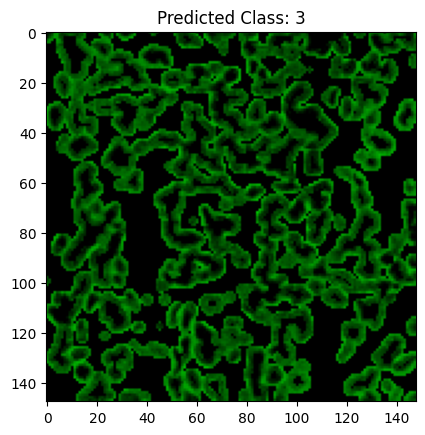

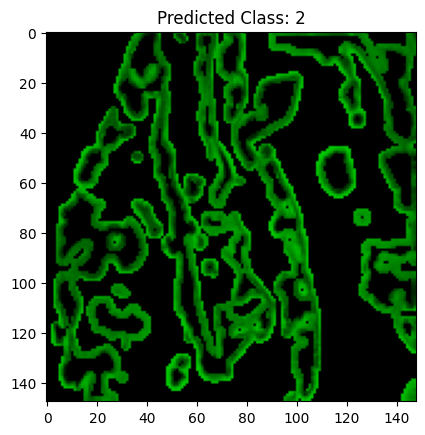

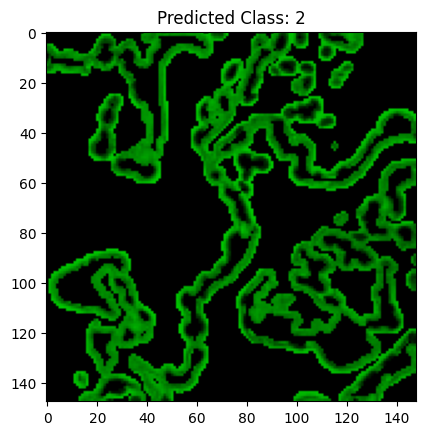

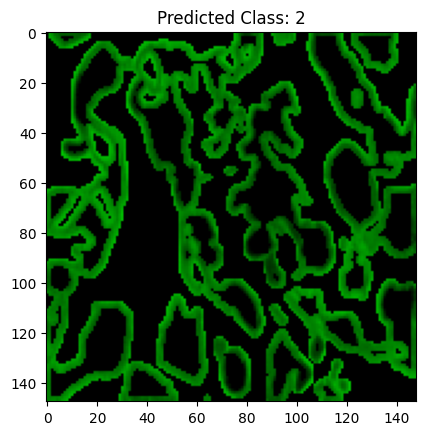

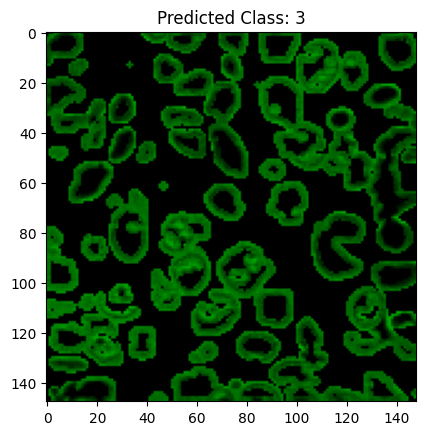

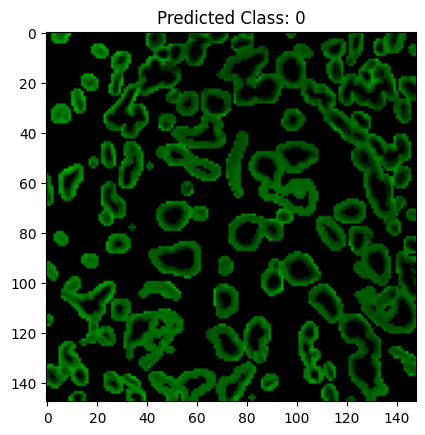

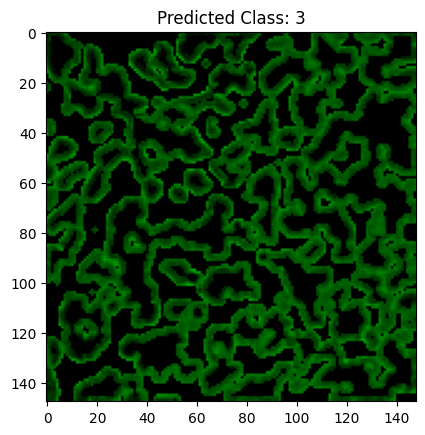

In [ ]:
#Predtion
predictions = hybrid_model1.predict(X_test[:10])

# argmax to translate the expected probability into class labels.
predicted_classes = np.argmax(predictions, axis=1)
print("Predicted classes for the first 10 images:", predicted_classes)

for i in range(10):

    matplotlib.imshow(X_test[i])
    matplotlib.title(f"Predicted Class: {predicted_classes[i]}")
    matplotlib.show()
